In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [3]:
train = pd.read_csv('/home/xiangliu/桌面/data challenge/titanic/train.csv')
test = pd.read_csv('/home/xiangliu/桌面/data challenge/titanic/test.csv')

In [6]:
train.shape,test.shape

((891, 12), (418, 11))

In [668]:
train.head(6)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q


we can see some basic infomation

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [5]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


#We found the attributes: age, cabin and embarked have missing values. The attribute 'cabin' only has 204 data. The attirbute 'age' missing more than 150 data. The attribute 'Embarked' only has 2 missing values, which has no influnce on this dataset. 
#There are about 38 percent people survived. 
#People's average age is 30( ignore missing values)

# Explore data

#The number of dead people are more than the number of survived people.
#There are more people in class 3 than in the other two classes.
#Male are more than female.
#People aged from 13 to 26 and 27 to 40 are the most

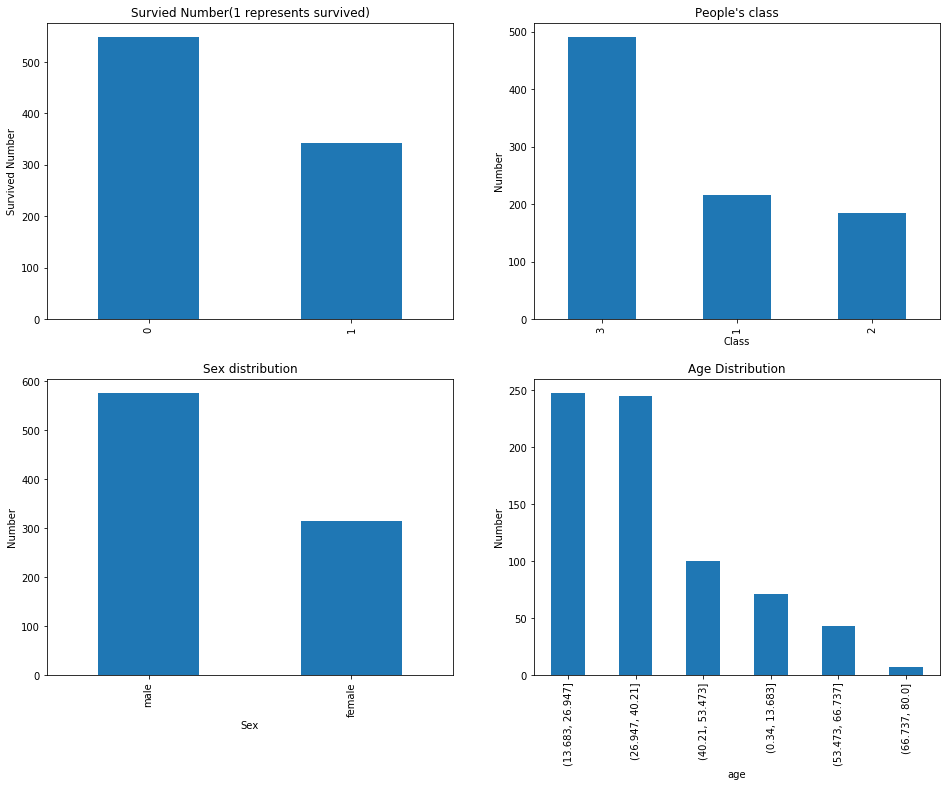

In [14]:
plt.figure(figsize=(16,12))

plt.subplot(2,2,1)
train.Survived.value_counts().plot(kind='bar')
plt.title('Survied Number(1 represents survived)')
plt.ylabel('Survived Number')

plt.subplot(2,2,2)
train.Pclass.value_counts().plot(kind='bar')
plt.title("People's class")
plt.xlabel('Class')
plt.ylabel('Number')

plt.subplot(2,2,4)
cats = pd.cut(train.Age,6)
cats.value_counts().plot(kind='bar')
plt.title('Age Distribution')
plt.xlabel('age')
plt.ylabel('Number')

plt.subplot(2,2,3)
train.Sex.value_counts().plot(kind='bar')
plt.title('Sex distribution')
plt.xlabel('Sex')
plt.ylabel('Number')

plt.show()

#Although, the number of male is much more than the number of female, female are more likely to be survived. Maybe because the principle 'Lady First'

Text(0, 0.5, 'Number')

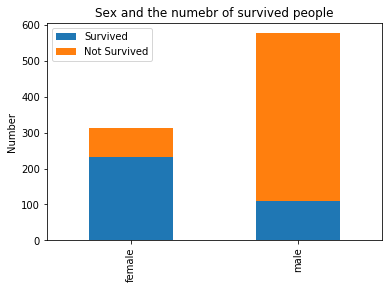

In [15]:
Survived_0 = train.Sex[train.Survived == 0].value_counts()
Survived_1 = train.Sex[train.Survived == 1].value_counts()
data1 = pd.DataFrame({'Survived':Survived_1,'Not Survived':Survived_0})
data1.plot(kind='bar',stacked=True)
plt.title('Sex and the numebr of survived people')
plt.ylabel('Number')

#Class 3 has the most people, but least ratio of survived.
#Class 1's people are more likely to be survived. Maybe because class 1's people are richer and have higher society status, which imporved the probility of be rescued

Text(0, 0.5, 'Number')

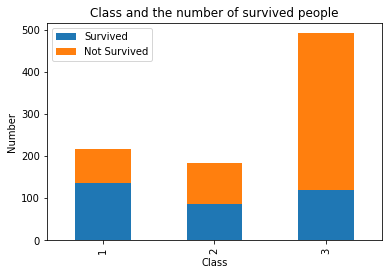

In [16]:
Survived_0 = train.Pclass[train.Survived == 0].value_counts()
Survived_1 = train.Pclass[train.Survived == 1].value_counts()
data2 = pd.DataFrame({'Survived':Survived_1,'Not Survived':Survived_0})
data2.plot(kind='bar',stacked=True)
plt.title('Class and the number of survived people')
plt.xlabel('Class')
plt.ylabel('Number')

#'Age' has more than 150 missing values, so we can't ignore the missing value. It is not a good idea to fill missing values with the mean of age. By observing the dataset, we found the attribute 'name' contains some title for people, like 'Miss','Mr'. Extract the title and calculate each title's average age, then fill the missing values with corresponding average age.

In [17]:
train['title'] = train['Name'].str.extract(' ([A-Za-z]+)\.',expand=False)

In [18]:
train['title'].shape

(891,)

In [19]:
mean_age = pd.DataFrame(train.groupby(train.title)['Age'].mean())
mean_age.rename(columns = {"Age": "mean_age"},  inplace=True)
mean_age

,mean_age
title,
Capt,70.000000
Col,58.000000
Countess,33.000000
Don,40.000000
Dr,42.000000
Jonkheer,38.000000
Lady,48.000000
Major,48.500000
Master,4.574167


#Above this, we found every name has a title, and for each title we can calculate the average age, for example, the title 'miss' 's average age is 22. We concat the train and test set together to get all age and name. By using more data, we will have more accuracy.

In [32]:
train = pd.merge(train,mean_age,left_on='title',right_index=True)

In [21]:
train.loc[ (train.Age.isnull()), 'Age' ] = train['mean_age'] 

In [22]:
train['Age'].shape

(891,)

In [23]:
df1 = pd.DataFrame({'Name':train['Name'],'Age':train['Age']})

In [24]:
df2 = pd.DataFrame({'Name':test['Name'],'Age':test['Age']})

In [25]:
df3 = pd.concat([df1,df2])

In [26]:
df3['title'] = df3['Name'].str.extract(' ([A-Za-z]+)\.',expand=False)

In [27]:
df3.head()

,Name,Age,title
0,"Braund, Mr. Owen Harris",22.00000,Mr
4,"Allen, Mr. William Henry",35.00000,Mr
5,"Moran, Mr. James",32.36809,Mr
6,"McCarthy, Mr. Timothy J",54.00000,Mr
12,"Saundercock, Mr. William Henry",20.00000,Mr


In [28]:
mean_ages = pd.DataFrame(df3.groupby(df3.title)['Age'].mean())
mean_ages.rename(columns = {"Age": "mean_ages"},  inplace=True)
mean_ages

,mean_ages
title,
Capt,70.000000
Col,54.000000
Countess,33.000000
Don,40.000000
Dona,39.000000
Dr,43.375000
Jonkheer,38.000000
Lady,48.000000
Major,48.500000


In [29]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,title,mean_age
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00000,1,0,A/5 21171,7.2500,NaN,S,Mr,32.36809
4,5,0,3,"Allen, Mr. William Henry",male,35.00000,0,0,373450,8.0500,NaN,S,Mr,32.36809
5,6,0,3,"Moran, Mr. James",male,32.36809,0,0,330877,8.4583,NaN,Q,Mr,32.36809
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.00000,0,0,17463,51.8625,E46,S,Mr,32.36809
12,13,0,3,"Saundercock, Mr. William Henry",male,20.00000,0,0,A/5. 2151,8.0500,NaN,S,Mr,32.36809


In [30]:
train = pd.merge(train,mean_ages,left_on='title',right_index=True,how='left')

In [688]:
train.loc[ (train.Age.isnull()), 'Age' ] = train['mean_ages'] 

We fill the missing values with corresponding average age, now there is no missing values in 'Age'

Divide the age into 4 groups: children, youth, middle age, old people. Children have more chance to be survived. Older people have less chance. The number of survived middle age is almost equal to the number of survived youth, but the total number of middle age people is larger, so the survival rate of youth is higher than the middle age people. 

Text(0.5, 0, 'age')

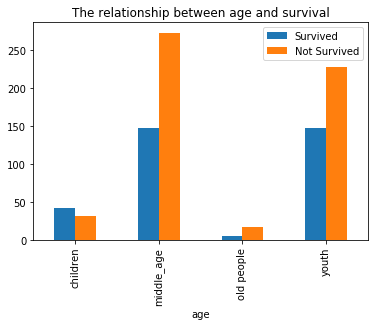

In [689]:
bins = [0,12,30,60,100]
train['age_class'] = pd.cut(train.Age,bins = bins,labels=['children','youth','middle_age','old people'])
su_1 = train.age_class[train.Survived == 1].value_counts()
su_0 = train.age_class[train.Survived == 0].value_counts()
data0 = pd.DataFrame({'Survived':su_1,'Not Survived':su_0})
data0.plot(kind = 'bar')
plt.title('The relationship between age and survival')
plt.xlabel('age')

# age_sex is not a good feature, so we won't use it. 
#In the figure 'Age and Survived of Female', we know that in different age classes, the number of survived female are more than the number of unsurvived female, especially in middle age female and youth female.
In the figure 'Age and Survived of male', we can only know,for male, the number of survived children are more than others.
#We label female who are in middle age and youth with 1, and label others with 0.(We don't label other female and the children male, that is because there are only a little more survived people than unsurvived people.If we choose these people, our model may be overfitting)

In [690]:
a = train.age_class[train['Survived']==1][train['Sex']=='male'].value_counts()
b = train.age_class[train['Survived']==1][train['Sex']=='female'].value_counts()
c = train.age_class[train['Survived']==0][train['Sex']=='male'].value_counts()
d = train.age_class[train['Survived']==0][train['Sex']=='female'].value_counts()

In [691]:
pd1 = pd.DataFrame({'Survived':a,'Not Survived':c})
pd2 = pd.DataFrame({'Survived':b,'Not Survived':d})

Text(0, 0.5, 'Number')

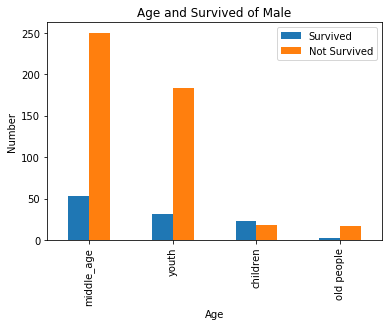

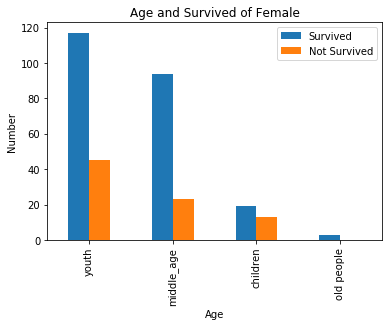

In [692]:
pd1.plot(kind='bar')
plt.title('Age and Survived of Male')
plt.xlabel('Age')
plt.ylabel('Number')

pd2.plot(kind = 'bar')
plt.title('Age and Survived of Female')
plt.xlabel('Age')
plt.ylabel('Number')

In [693]:
train['age_sex']=''

In [694]:
train.loc[((train['age_class']=='youth')|(train['age_class']=='middle_age'))&(train['Sex']=='female'),'age_sex']=1

In [695]:
train.loc[train.age_sex =='','age_sex'] = 0

Explore the relationship between the number of survived and the number of their siblings, we found people with more than 3 siblings had less opptunity to be survived. But it's not obvious to say that more siblings, less survival, because sample is small. Meanwhile, the relationship amoung people who has less than 3 siblings is not obvious, too. 

Text(0.5, 1.0, 'the number of siblings and the number of survived people')

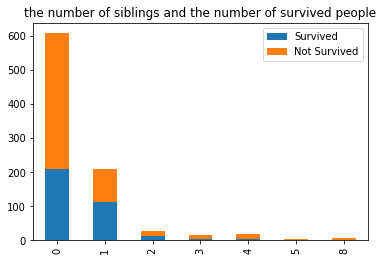

In [35]:
sur_1 = train.SibSp[train.Survived == 1].value_counts()
sur_0 = train.SibSp[train.Survived == 0].value_counts()
data3 = pd.DataFrame({'Survived':sur_1,'Not Survived':sur_0})
data3.plot(kind='bar',stacked=True)
plt.title('the number of siblings and the number of survived people')

Analyze the relationship between the number of survived people and the number of parents and children, we found the result is like the relationship between the number of survived people and the number of siblings. The relationship is not obvious.

Text(0.5, 1.0, 'the number of parents and children and the number of survived people')

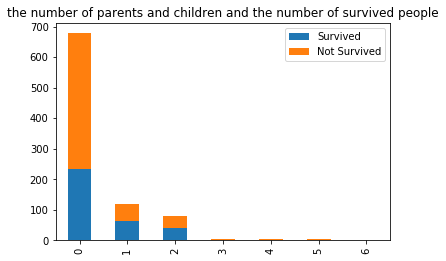

In [697]:
suri_1 = train.Parch[train.Survived == 1].value_counts()
suri_0 = train.Parch[train.Survived == 0].value_counts()
data4 = pd.DataFrame({'Survived':suri_1,'Not Survived':suri_0})
data4.plot(kind='bar',stacked=True)
plt.title('the number of parents and children and the number of survived people')

We create a new feature 'family', which is the sum of 'Parch' and 'SibSp'.It's not obvious to say the relationship between the number of  family and the number of survived people. So we can temporarily ignore the feature 'Parch','SibSp' and 'family'

Text(0.5, 1.0, 'the number of family and the number of survived people')

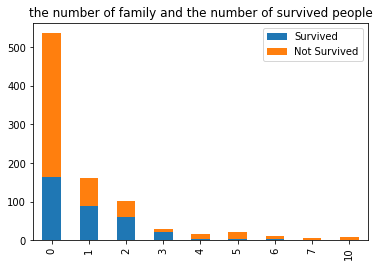

In [34]:
train['family'] = train.SibSp + train.Parch
survi_1 = train.family[train.Survived == 1].value_counts()
survi_0 = train.family[train.Survived == 0].value_counts()
data5 = pd.DataFrame({'Survived':survi_1,'Not Survived':survi_0})
data5.plot(kind='bar',stacked=True)
plt.title('the number of family and the number of survived people')

There are 681 unique tickets. With more details, 547 tickets are used by one people and 94 tickets are used by two people. We have no idea why they use same tickets, maybe because there are family.

In [699]:
value,count= np.unique(train.Ticket,return_counts=True)
len(value)

681

In [700]:
data6 = pd.DataFrame(zip(value,count))
data6.columns = [['value','number']]

In [701]:
a,b = np.unique(data6.number,return_counts=True)
data7 = pd.DataFrame(zip(a,b))
data7.columns = [['ticket','count']]
data7

,ticket,count
0,1,547
1,2,94
2,3,21
3,4,11
4,5,2
5,6,3
6,7,3


'Cabin' feature is composed by letter and number. We assume the letter represents cabin number and the number represents the seat number.Then we extract the cabin number from this feature. We found there are 687 people don't have a cabin number, so we fill this missing value with 'none'. 

In [702]:
train['cabin_title'] = train['Cabin'].str.extract('([A-Za-z]+)',expand=False) 

In [703]:
train.loc[ (train.cabin_title.isnull()), 'cabin_title' ] = 'none' 

In [704]:
train['cabin_title'].value_counts()

none    687
C        59
B        47
D        33
E        32
A        15
F        13
G         4
T         1
Name: cabin_title, dtype: int64

People without cabin number have less chance to survived. I assume that these people are poor and has worse cabin, so it's more difficult for them to escape. People with cabin numbers have no obvious difference between survived and not survived. Thus, we can consider this feather into 2 situations: with cabin number(1) and without(0).

Text(0.5, 1.0, "the relationship between people's cabin and survived number")

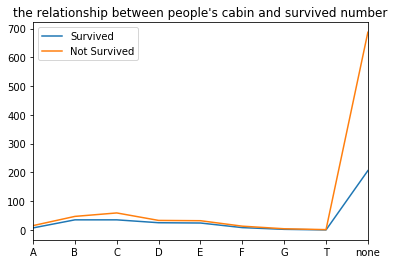

In [705]:
surviv_1 = train.cabin_title[train.Survived == 1].value_counts()
surviv_0 = train.cabin_title[train.Survived == 0].value_counts()
data8 = pd.DataFrame({'Survived':surviv_1,'Not Survived':surviv_0})
data8.plot(kind = 'line',stacked=True)
plt.title("the relationship between people's cabin and survived number")

In [706]:
train.loc[ (train.cabin_title =='none'), 'cabin_status' ] = 0 
train.loc[ (train.cabin_title != 'none'), 'cabin_status' ] = 1 

The number of survived people embarked at S is less than dead people. In port C and port Q, there are no obvious relationships.

Text(0.5, 1.0, 'the relationship between embarked and survived number')

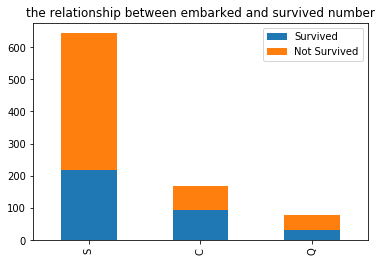

In [707]:
survive_1 = train.Embarked[train.Survived == 1].value_counts()
survive_0 = train.Embarked[train.Survived == 0].value_counts()
data9 = pd.DataFrame({'Survived':survive_1,'Not Survived':survive_0})
data9.plot(kind = 'bar',stacked=True)
plt.title("the relationship between embarked and survived number")

In [708]:
embarked_dummies  = pd.get_dummies(train['Embarked'])
train = train.join(embarked_dummies)
train.drop(['Embarked'], axis=1,inplace=True)

In [709]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,mean_age,mean_ages,age_class,age_sex,family,cabin_title,cabin_status,C,Q,S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00000,1,0,A/5 21171,7.2500,...,32.36809,32.271861,youth,0,1,none,0.0,0,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.00000,0,0,373450,8.0500,...,32.36809,32.271861,middle_age,0,0,none,0.0,0,0,1
5,6,0,3,"Moran, Mr. James",male,32.36809,0,0,330877,8.4583,...,32.36809,32.271861,middle_age,0,0,none,0.0,0,1,0
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.00000,0,0,17463,51.8625,...,32.36809,32.271861,middle_age,0,0,E,1.0,0,0,1
12,13,0,3,"Saundercock, Mr. William Henry",male,20.00000,0,0,A/5. 2151,8.0500,...,32.36809,32.271861,youth,0,0,none,0.0,0,0,1


# Do not think of labeling 1 and 0 for the feature. It doesn't work. I can not decide the classification!!!!!!!

In [712]:
#train['Embarked_label'] = ''
#train.loc[train["Embarked"]=='S',"Embarked_label"] = 1
#train.loc[train['Embarked_label']=='','Embarked_label']=0

In [713]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,mean_ages,age_class,age_sex,family,cabin_title,cabin_status,C,Q,S,Embarked_label
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00000,1,0,A/5 21171,7.2500,...,32.271861,youth,0,1,none,0.0,0,0,1,
4,5,0,3,"Allen, Mr. William Henry",male,35.00000,0,0,373450,8.0500,...,32.271861,middle_age,0,0,none,0.0,0,0,1,
5,6,0,3,"Moran, Mr. James",male,32.36809,0,0,330877,8.4583,...,32.271861,middle_age,0,0,none,0.0,0,1,0,
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.00000,0,0,17463,51.8625,...,32.271861,middle_age,0,0,E,1.0,0,0,1,
12,13,0,3,"Saundercock, Mr. William Henry",male,20.00000,0,0,A/5. 2151,8.0500,...,32.271861,youth,0,0,none,0.0,0,0,1,


Divide the passengers into four group evenly according to the fare. People with high price's ticket are more likely to be survived.

Text(0.5, 1.0, "the relationship between ticket's fare and people survived")

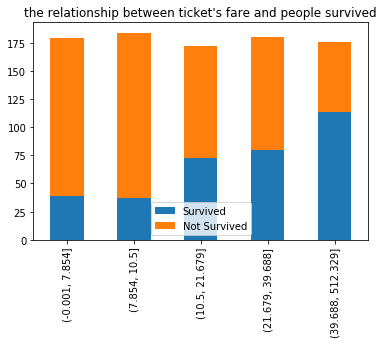

In [714]:
train['fare_class'] = pd.qcut(train.Fare,q=5)
s_1 = train.fare_class[train.Survived == 1].value_counts()
s_0 = train.fare_class[train.Survived == 0].value_counts()
data10 = pd.DataFrame({'Survived':s_1,'Not Survived':s_0})
data10.plot(kind = 'bar',stacked=True)
plt.title("the relationship between ticket's fare and people survived")

After exploring the data, we found feature 'SibSp', 'ticket', 'Embarked' and feature 'Parch' don't have obvious relationships with the number of survived people. So we can temporarily ignore them.

The feature 'sex', 'age', 'Pclass', 'Fare', 'Cabin' can be used in our model

# Feature Preprocessing

The range of age and the range of fare is very different. In order to improve accuracy, we use feature scaling to stardard the data.

In [715]:
train_set = train[['Survived','Pclass','Sex','Age','Fare','cabin_status','C','Q','S','Parch','SibSp']]
train_set.head()

,Survived,Pclass,Sex,Age,Fare,cabin_status,C,Q,S,Parch,SibSp
0,0,3,male,22.00000,7.2500,0.0,0,0,1,0,1
4,0,3,male,35.00000,8.0500,0.0,0,0,1,0,0
5,0,3,male,32.36809,8.4583,0.0,0,1,0,0,0
6,0,1,male,54.00000,51.8625,1.0,0,0,1,0,0
12,0,3,male,20.00000,8.0500,0.0,0,0,1,0,0


In [716]:
std = StandardScaler()
train_set['Age_scaled'] = std.fit_transform(train_set.Age.values.reshape(-1,1))
train_set['Fare_scaled'] = std.fit_transform(train_set.Fare.values.reshape(-1,1))

/home/xiangliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/xiangliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [717]:
train_set.drop(['Age','Fare'],axis=1,inplace=True)

/home/xiangliu/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


The type of feature 'Sex' is not numeric, so we should transform the type into numeric

In [718]:
sex_dummies  = pd.get_dummies(train_set['Sex'])
train_set = train_set.join(sex_dummies)
train_set.drop(['Sex'], axis=1,inplace=True)

In [719]:
train_set.head()

,Survived,Pclass,cabin_status,C,Q,S,Parch,SibSp,Age_scaled,Fare_scaled,female,male
0,0,3,0.0,0,0,1,0,1,-0.584387,-0.502445,0,1
4,0,3,0.0,0,0,1,0,0,0.395286,-0.486337,0,1
5,0,3,0.0,0,1,0,0,0,0.196947,-0.478116,0,1
6,0,1,1.0,0,0,1,0,0,1.827117,0.395814,0,1
12,0,3,0.0,0,0,1,0,0,-0.735106,-0.486337,0,1


# Logistic Regression

By using logistic regression, we can classify people into two class: survived and not survived. After inputing the train set, we can get a model.

In [720]:
features = ['Pclass','cabin_status','Age_scaled','Fare_scaled','female','male','C','Q','S','Parch','SibSp']
X = train_set[features]
y = train_set['Survived']
clf = LogisticRegression(solver='lbfgs')
clf.fit(X,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Then, we should explore our test dataset in the same way.

Consider two situations: with cabin number(1),without(0)

In [721]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [722]:
test['cabin_title'] = test['Cabin'].str.extract('([A-Za-z]+)',expand=False)
test.loc[ (test.cabin_title.isnull()), 'cabin_title' ] = 'none' 
test.loc[ (test.cabin_title =='none'), 'cabin_status' ] = 0 
test.loc[ (test.cabin_title != 'none'), 'cabin_status' ] = 1

In [723]:
embarked_dummies1  = pd.get_dummies(test['Embarked'])
test = test.join(embarked_dummies1)
test.drop(['Embarked'], axis=1,inplace=True)

We fill the missing value in test dataset with average age calculated in train dataset, that is because train set has more data than test data, the average age is more accuracy.

In [724]:
test['title'] = test['Name'].str.extract(' ([A-Za-z]+)\.',expand=False)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 16 columns):
PassengerId     418 non-null int64
Pclass          418 non-null int64
Name            418 non-null object
Sex             418 non-null object
Age             332 non-null float64
SibSp           418 non-null int64
Parch           418 non-null int64
Ticket          418 non-null object
Fare            417 non-null float64
Cabin           91 non-null object
cabin_title     418 non-null object
cabin_status    418 non-null float64
C               418 non-null uint8
Q               418 non-null uint8
S               418 non-null uint8
title           418 non-null object
dtypes: float64(3), int64(4), object(6), uint8(3)
memory usage: 43.8+ KB


In [725]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,cabin_title,cabin_status,C,Q,S,title
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,none,0.0,0,1,0,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,none,0.0,0,0,1,Mrs
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,none,0.0,0,1,0,Mr
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,none,0.0,0,0,1,Mr
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,none,0.0,0,0,1,Mrs


In [727]:
test1 = test[['PassengerId','Pclass','Sex','Age','Fare','cabin_status','title','C','Q','S','Parch','SibSp']]

In [728]:
test1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
PassengerId     418 non-null int64
Pclass          418 non-null int64
Sex             418 non-null object
Age             332 non-null float64
Fare            417 non-null float64
cabin_status    418 non-null float64
title           418 non-null object
C               418 non-null uint8
Q               418 non-null uint8
S               418 non-null uint8
Parch           418 non-null int64
SibSp           418 non-null int64
dtypes: float64(3), int64(4), object(2), uint8(3)
memory usage: 30.7+ KB


In [729]:
test2 = pd.merge(test1,mean_ages,left_on='title',right_index=True,how='left')

In [730]:
test2.head()

,PassengerId,Pclass,Sex,Age,Fare,cabin_status,title,C,Q,S,Parch,SibSp,mean_ages
0,892,3,male,34.5,7.8292,0.0,Mr,0,1,0,0,0,32.271861
1,893,3,female,47.0,7.0000,0.0,Mrs,0,0,1,0,1,36.894484
2,894,2,male,62.0,9.6875,0.0,Mr,0,1,0,0,0,32.271861
3,895,3,male,27.0,8.6625,0.0,Mr,0,0,1,0,0,32.271861
4,896,3,female,22.0,12.2875,0.0,Mrs,0,0,1,1,1,36.894484


In [731]:
test2.loc[ (test2.Age.isnull()), 'Age' ] = test2['mean_ages'] 

In [732]:
test2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 13 columns):
PassengerId     418 non-null int64
Pclass          418 non-null int64
Sex             418 non-null object
Age             418 non-null float64
Fare            417 non-null float64
cabin_status    418 non-null float64
title           418 non-null object
C               418 non-null uint8
Q               418 non-null uint8
S               418 non-null uint8
Parch           418 non-null int64
SibSp           418 non-null int64
mean_ages       418 non-null float64
dtypes: float64(4), int64(4), object(2), uint8(3)
memory usage: 34.0+ KB


In [733]:
test2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 13 columns):
PassengerId     418 non-null int64
Pclass          418 non-null int64
Sex             418 non-null object
Age             418 non-null float64
Fare            417 non-null float64
cabin_status    418 non-null float64
title           418 non-null object
C               418 non-null uint8
Q               418 non-null uint8
S               418 non-null uint8
Parch           418 non-null int64
SibSp           418 non-null int64
mean_ages       418 non-null float64
dtypes: float64(4), int64(4), object(2), uint8(3)
memory usage: 34.0+ KB


In [734]:
test2[test2['Fare'].isnull()]

,PassengerId,Pclass,Sex,Age,Fare,cabin_status,title,C,Q,S,Parch,SibSp,mean_ages
152,1044,3,male,60.5,NaN,0.0,Mr,0,0,1,0,0,32.271861


In [735]:
train[train['Pclass']==3].Fare.mean()

13.675550101832988

In [736]:
test2.loc[(test2.Fare.isnull()), 'Fare'] = 13.68

In [737]:
test2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 13 columns):
PassengerId     418 non-null int64
Pclass          418 non-null int64
Sex             418 non-null object
Age             418 non-null float64
Fare            418 non-null float64
cabin_status    418 non-null float64
title           418 non-null object
C               418 non-null uint8
Q               418 non-null uint8
S               418 non-null uint8
Parch           418 non-null int64
SibSp           418 non-null int64
mean_ages       418 non-null float64
dtypes: float64(4), int64(4), object(2), uint8(3)
memory usage: 34.0+ KB


Use feature scaling on the feature 'Age' and 'Fare'

In [738]:
test2.head()

,PassengerId,Pclass,Sex,Age,Fare,cabin_status,title,C,Q,S,Parch,SibSp,mean_ages
0,892,3,male,34.5,7.8292,0.0,Mr,0,1,0,0,0,32.271861
1,893,3,female,47.0,7.0000,0.0,Mrs,0,0,1,0,1,36.894484
2,894,2,male,62.0,9.6875,0.0,Mr,0,1,0,0,0,32.271861
3,895,3,male,27.0,8.6625,0.0,Mr,0,0,1,0,0,32.271861
4,896,3,female,22.0,12.2875,0.0,Mrs,0,0,1,1,1,36.894484


In [739]:
std_1 = StandardScaler()
test2['Age_scaled'] = std_1.fit_transform(test2.Age.values.reshape(-1,1))
test2['Fare_scaled'] = std_1.fit_transform(test2.Fare.values.reshape(-1,1))

Transform the type into numeric

In [740]:
test2.head()

,PassengerId,Pclass,Sex,Age,Fare,cabin_status,title,C,Q,S,Parch,SibSp,mean_ages,Age_scaled,Fare_scaled
0,892,3,male,34.5,7.8292,0.0,Mr,0,1,0,0,0,32.271861,0.332462,-0.497374
1,893,3,female,47.0,7.0000,0.0,Mrs,0,0,1,0,1,36.894484,1.293499,-0.512238
2,894,2,male,62.0,9.6875,0.0,Mr,0,1,0,0,0,32.271861,2.446742,-0.464061
3,895,3,male,27.0,8.6625,0.0,Mr,0,0,1,0,0,32.271861,-0.244159,-0.482436
4,896,3,female,22.0,12.2875,0.0,Mrs,0,0,1,1,1,36.894484,-0.628574,-0.417453


In [741]:
sex_dummies1  = pd.get_dummies(test2['Sex'])
test2 = test2.join(sex_dummies1)
test2.drop(['Sex'], axis=1,inplace=True)

In [742]:
test2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 16 columns):
PassengerId     418 non-null int64
Pclass          418 non-null int64
Age             418 non-null float64
Fare            418 non-null float64
cabin_status    418 non-null float64
title           418 non-null object
C               418 non-null uint8
Q               418 non-null uint8
S               418 non-null uint8
Parch           418 non-null int64
SibSp           418 non-null int64
mean_ages       418 non-null float64
Age_scaled      418 non-null float64
Fare_scaled     418 non-null float64
female          418 non-null uint8
male            418 non-null uint8
dtypes: float64(6), int64(4), object(1), uint8(5)
memory usage: 38.0+ KB


Drop irrelevant features

In [743]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,cabin_title,cabin_status,C,Q,S,title
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,none,0.0,0,1,0,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,none,0.0,0,0,1,Mrs
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,none,0.0,0,1,0,Mr
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,none,0.0,0,0,1,Mr
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,none,0.0,0,0,1,Mrs


In [744]:
#features1 = test['Pclass','cabin_status','Age_scaled','Fare_scaled','female','male']
X_test = test2[features]

In [745]:
X_test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
Pclass          418 non-null int64
cabin_status    418 non-null float64
Age_scaled      418 non-null float64
Fare_scaled     418 non-null float64
female          418 non-null uint8
male            418 non-null uint8
C               418 non-null uint8
Q               418 non-null uint8
S               418 non-null uint8
Parch           418 non-null int64
SibSp           418 non-null int64
dtypes: float64(3), int64(3), uint8(5)
memory usage: 21.7 KB


In [746]:
data15 = pd.DataFrame({'features':list(train_set.columns)[1:],'coef':list(clf.coef_.T)})


In [747]:
data15

,features,coef
0,Pclass,[-0.8908310120200073]
1,cabin_status,[0.6491890276140172]
2,C,[-0.5613166888565918]
3,Q,[0.06376223751672193]
4,S,[1.3237315749663072]
5,Parch,[-1.3223195764444013]
6,SibSp,[0.12345961554493094]
7,Age_scaled,[-0.03332295179221276]
8,Fare_scaled,[-0.2820211097689929]
9,female,[-0.0986105594292643]


In [748]:
y_pred = clf.predict(X_test)

In [749]:
y_pred.shape

(418,)

# Gaussian Bayes

In [750]:
from sklearn.naive_bayes import GaussianNB

In [751]:
gaussian = GaussianNB()
gaussian.fit(X,y)

GaussianNB(priors=None, var_smoothing=1e-09)

In [752]:
y_pred1 = gaussian.predict(X_test)

# We split the train set. We use part of the train set(20% in this case) to test the model.
# By using logistic and naive bayes, we know different models have different results(result 4 and result 5), so we should try more models.


In [753]:
# split the train set

In [754]:
predictors = X
target = y

In [755]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(predictors, target, test_size = 0.20, random_state = 0)

In [756]:
# test different models

In [757]:
# Gaussian Bayes

In [758]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

gaussian = GaussianNB()
gaussian.fit(x_train, y_train)
y_pred = gaussian.predict(x_val)
acc_gaussian = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_gaussian)

79.89


In [759]:
# logistic regression

In [760]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(x_train, y_train)
y_pred = logreg.predict(x_val)
acc_logreg = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_logreg)

82.12


/home/xiangliu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [761]:
#SVM

In [762]:
from sklearn.svm import SVC

svc = SVC()
svc.fit(x_train, y_train)
y_pred = svc.predict(x_val)
acc_svc = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_svc)

84.36


/home/xiangliu/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [763]:
# linear SVC

In [764]:
from sklearn.svm import LinearSVC

linear_svc = LinearSVC()
linear_svc.fit(x_train, y_train)
y_pred = linear_svc.predict(x_val)
acc_linear_svc = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_linear_svc)

81.01


/home/xiangliu/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [765]:
# decision tree

In [766]:
from sklearn.tree import DecisionTreeClassifier

decisiontree = DecisionTreeClassifier()
decisiontree.fit(x_train, y_train)
y_pred = decisiontree.predict(x_val)
acc_decisiontree = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_decisiontree)

74.3


In [767]:
# random forest

In [768]:
from sklearn.ensemble import RandomForestClassifier

randomforest = RandomForestClassifier()
randomforest.fit(x_train, y_train)
y_pred = randomforest.predict(x_val)
acc_randomforest = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_randomforest)

80.45


/home/xiangliu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [769]:
# Gradient Boosting Classifier

In [770]:
from sklearn.ensemble import GradientBoostingClassifier

gbk = GradientBoostingClassifier()
gbk.fit(x_train, y_train)
y_pred = gbk.predict(x_val)
acc_gbk = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_gbk)

79.89


# Cross Validation

In [771]:
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction

In [772]:
kfold = KFold(n_splits=10, random_state=22) # k=10, split the data into 10 equal parts
xyz=[]
accuracy=[]
std=[]
classifiers=['Support Vector Machines', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Linear SVC', 
              'Decision Tree',  'Gradient Boosting Classifier']
models=[SVC(), LogisticRegression(), RandomForestClassifier(), GaussianNB(), 
        LinearSVC(), DecisionTreeClassifier(),  
        GradientBoostingClassifier()]
for i in models:
    model = i
    cv_result = cross_val_score(model,X,y, cv = kfold,scoring = "accuracy")
    xyz.append(cv_result.mean())
    std.append(cv_result.std())
    accuracy.append(cv_result)
new_models_dataframe2=pd.DataFrame({'CV Mean':xyz,'Std':std},index=classifiers)       
new_models_dataframe2

/home/xiangliu/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/xiangliu/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/xiangliu/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/xiangliu/anaconda3/lib/python3.7/site-packa

/home/xiangliu/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/xiangliu/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/xiangliu/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/xiangliu/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/xiangliu/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the num

,CV Mean,Std
Support Vector Machines,0.806891,0.067322
Logistic Regression,0.783296,0.058821
Random Forest,0.778851,0.064099
Naive Bayes,0.775568,0.047208
Linear SVC,0.779913,0.069492
Decision Tree,0.755318,0.043520
Gradient Boosting Classifier,0.802422,0.055677


In [782]:
y_pred2 = svm.predict(X_test)

In [783]:
result = pd.DataFrame({'PassengerId':test['PassengerId'].as_matrix(), 'Survived':y_pred2.astype(np.int32)})

/home/xiangliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [784]:
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 2 columns):
PassengerId    418 non-null int64
Survived       418 non-null int32
dtypes: int32(1), int64(1)
memory usage: 5.0 KB


In [785]:
result.to_csv("result_Titanic8.csv", index=False)